In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import scipy.sparse
from ion_ct_data.straight_projection import PatientCT, Projector, ProjectorNoFortran
from ion_ct_data.helpers.plotting import plot_comparison, plot_projections

import torch

def generate_system_matrix(shape, angles):
    system_matrices_angles = {}
    for i, theta in enumerate(angles):
        system_matrix = np.zeros(shape=(np.prod(shape), shape[0]))
        for row_index in range(shape[0]):
            image_zeros = np.zeros(shape)
            image_zeros[row_index, :] = 1
            image_rotated = rotate(image_zeros, theta, reshape=False, order=1)
            image_row = image_rotated.reshape(np.prod(shape), order='F')
            system_matrix[:, row_index] = image_row
        system_matrix = scipy.sparse.csc_matrix(system_matrix)
        system_matrices_angles[theta] = system_matrix
    return system_matrices_angles

def forward_projection(system_matrix, image):
    return system_matrix @ image.flatten(order='F')

def back_projection(system_matrix, sinogram):
    return (system_matrix.transpose() @ sinogram).reshape(system_matrix.shape[1], system_matrix.shape[1], order='F')

In [2]:
# Instantiate the PatientCT class with the patient's name
patient_name = 'male1'  # replace with the actual patient's name
patient = PatientCT(patient_name)

# The CT data is now loaded and can be accessed via the `ct` attribute
ct_data = patient.ct

angles = np.linspace(0, 180, 10, endpoint=False)

projector = Projector(slice_shape=patient.slice_shape, angles=angles)
projections = projector.generate(patient)

projections

projections_nof_array = np.stack([val for val in projections.values()])


0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/j/J.Titze/pycharm_remote/remote_data/ion_ct_data/straight_projection.py:253: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /croot/pytorch-select_1700158693612/work/torch/csrc/utils/tensor_new.cpp:605.)
  sys_coo_tensor = torch.sparse.FloatTensor(indices_tensor, system_matrix_masked_tensor,


In [3]:
reconstructed_nof = np.zeros(patient.ct.shape)

for slice in range(projections_nof_array.shape[1]):
    projection_slice = projections_nof_array[:, slice, :]
    reconstructed_angles = []
    for index, angle in enumerate(angles):
        system_matrix = projector.system_matrices[angle]
        mask_image = patient.mask[slice]
        system_matrix_masked = system_matrix#.multiply(mask_image.flatten('F')[:, np.newaxis])
        system_matrix_norm = projector.normalize_system_matrix(system_matrix_masked)
        projection_angle = projection_slice[index, :]
        reconstructed_angle = system_matrix_norm @ projection_angle
        reconstructed_angle = reconstructed_angle.reshape(patient.slice_shape)
        reconstructed_angles.append(reconstructed_angle)
    reconstructed_slice = np.stack(reconstructed_angles, axis=0)
    reconstructed_slice = np.sum(reconstructed_slice, axis=0)
    reconstructed_nof[slice, : , :] = reconstructed_slice

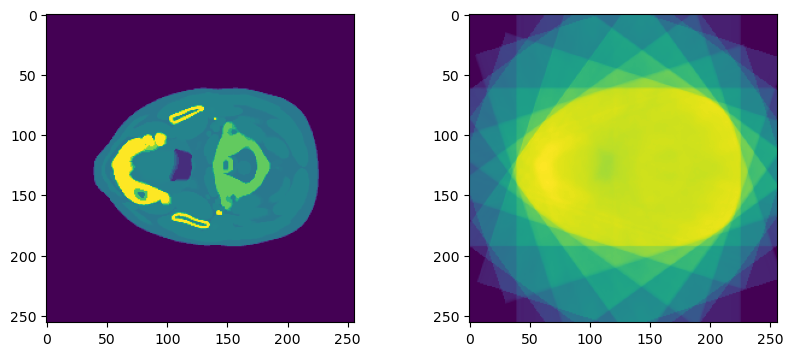

In [4]:
#plot original ct, sinogram and reconstructed ct
slice_index = 25

plot_comparison(patient.ct[slice_index, :, :], reconstructed_nof[slice_index, :, :])

In [11]:
# Instantiate the PatientCT class with the patient's name
patient_name = 'male1'  # replace with the actual patient's name
patient = PatientCT(patient_name)

# The CT data is now loaded and can be accessed via the `ct` attribute
ct_data = patient.ct

angles = np.linspace(0, 180, 10, endpoint=False)

projector_nof = ProjectorNoFortran(slice_shape=patient.slice_shape, angles=angles)
projections_nof = projector_nof.generate(patient)

projections_nof

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{0.0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 18.0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 36.0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 54.0: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., .

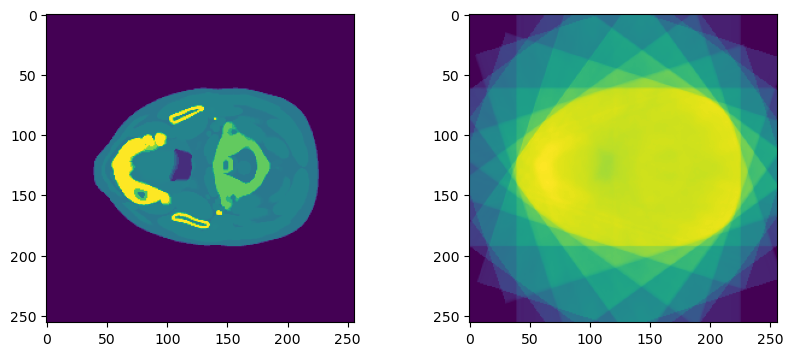

In [12]:
projections_nof_array = np.stack([val for val in projections_nof.values()])

reconstructed_nof = np.zeros(patient.ct.shape)

for slice in range(projections_nof_array.shape[1]):
    projection_slice = projections_nof_array[:, slice, :]
    reconstructed_angles = []
    for index, angle in enumerate(angles):
        system_matrix = projector_nof.system_matrices[angle]
        mask_image = patient.mask[slice]
        system_matrix_masked = system_matrix  #.multiply(mask_image.flatten('F')[:, np.newaxis])
        system_matrix_norm = projector_nof.normalize_system_matrix(system_matrix_masked)
        projection_angle = projection_slice[index, :]
        reconstructed_angle = system_matrix_norm @ projection_angle
        reconstructed_angle = reconstructed_angle.reshape(patient.slice_shape)
        reconstructed_angles.append(reconstructed_angle)
    reconstructed_slice = np.stack(reconstructed_angles, axis=0)
    reconstructed_slice = np.sum(reconstructed_slice, axis=0)
    reconstructed_nof[slice, :, :] = reconstructed_slice
#plot original ct, sinogram and reconstructed ct
slice_index = 25

plot_comparison(patient.ct[slice_index, :, :], reconstructed_nof[slice_index, :, :])